In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from warnings import filterwarnings
filterwarnings("ignore")

In [14]:
comments_df = pd.read_csv("train_data.csv")
comments_df.head()

,comment,toxic
0,Преступление и наказание\n,0.0
1,"И именно эти неработающие весы показывают, что...",0.0
2,"В Японии такие панельки, ебанько.\n",0.0
3,Еще у нас выявляют трещины с помощью белой кра...,0.0
4,"Дочитал до поезда в Норильск , дальше не стал\n",0.0


In [41]:
comments_df.describe()

,toxic
count,10809.000000
mean,0.333796
std,0.471590
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [42]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10809 entries, 0 to 10808
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  10809 non-null  object 
 1   toxic    10809 non-null  float64
dtypes: float64(1), object(1)
memory usage: 169.0+ KB


In [43]:
comments_df["toxic"] = comments_df["toxic"].apply(int)

In [44]:
comments_df.isna().sum()

comment    0
toxic      0
dtype: int64

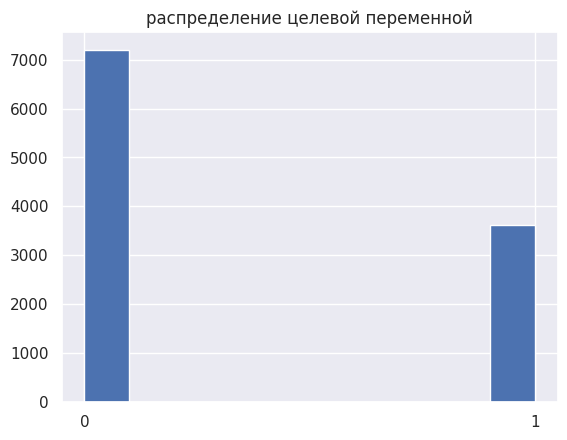

In [45]:
sns.set_theme()
plt.title("распределение целевой переменной")
comments_df["toxic"].hist()
plt.xticks([0, 1])
plt.show()

# Мешок слов, Base line

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
ngram_range = (1, 1) # количество слов (н-грамм) для токена
regexp = "\w{3,}"    # слова, минимальной длинной 3 

vec = CountVectorizer(ngram_range=ngram_range, token_pattern=regexp)

In [10]:
X = comments_df["comment"]
y = comments_df["toxic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
vec.fit(X_train)

CountVectorizer(token_pattern='\\w{3,}')

In [12]:
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [13]:
model = LogisticRegression(random_state=0, max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1595
           1       0.62      0.83      0.71       567

    accuracy                           0.82      2162
   macro avg       0.78      0.83      0.79      2162
weighted avg       0.85      0.82      0.83      2162



In [135]:
X_train.shape

(8647, 48167)

# Tfidf

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from functools import lru_cache

import pymorphy3

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/egor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/egor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
reg = re.compile("[А-Яа-яёЁ]+")
morph = pymorphy3.MorphAnalyzer()
stop_words = stopwords.words("russian")


def only_words(text, reg=reg):
    try:
        return reg.findall(text.lower())
    except:
        return []
    

@lru_cache(maxsize=128)
def lemmatize_word(token, morph=morph):
    return morph.parse(token)[0].normal_form


def lemmatize_sentence(sentence):
    return [lemmatize_word(w) for w in sentence]


def remove_stops(lemmas, stopwords=stop_words):
    return [w for w in lemmas if w not in stopwords and len(w) > 3]


def clean_text(text):
    tokens = only_words(text)
    lemmas = lemmatize_sentence(tokens)
    return " ".join(remove_stops(lemmas))

In [80]:
lemmatize_word("неработающие")

'неработающий'

In [139]:
X[1]

'И именно эти неработающие весы показывают, что работающих нет?..\n'

In [140]:
clean_text(X[1])

'именно неработающий весы показывать работать'

In [81]:
X = comments_df["comment"].apply(clean_text)
y = comments_df["toxic"]

In [82]:
print(X[0], "|", comments_df["comment"][0])

преступление наказание | Преступление и наказание



In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [172]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), analyzer="word", max_features=30_000)
tfidf.fit(X_train)

TfidfVectorizer(max_features=30000, ngram_range=(1, 3))

In [173]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [174]:
X_train.shape

(8647, 30000)

In [175]:
model = LogisticRegression(random_state=0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [176]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87      1712
         1.0       0.54      0.91      0.68       450

    accuracy                           0.82      2162
   macro avg       0.75      0.85      0.77      2162
weighted avg       0.88      0.82      0.83      2162



# Word2Vec

In [138]:
from gensim.models import Word2Vec  
import gensim.downloader as api
from nltk.tokenize import word_tokenize

In [139]:
comments_df.head()

,comment,toxic
0,Преступление и наказание\n,0.0
1,"И именно эти неработающие весы показывают, что...",0.0
2,"В Японии такие панельки, ебанько.\n",0.0
3,Еще у нас выявляют трещины с помощью белой кра...,0.0
4,"Дочитал до поезда в Норильск , дальше не стал\n",0.0


In [140]:
import pymorphy3
import numpy as np
morph = pymorphy3.MorphAnalyzer()

In [141]:
comments_df["comment"].values[0]

'Преступление и наказание\n'

In [142]:
tokenized_tweet =  [word_tokenize(morph.parse(i)[0].normal_form) for i in comments_df["comment"].values]
print(tokenized_tweet[0])

['преступление', 'и', 'наказание']


In [143]:
w2v = Word2Vec(tokenized_tweet, vector_size=300, min_count=10, window=3, sample=0.001, workers=3)

In [145]:
def mean_embedding(sentence, model=w2v):
    res = np.zeros(300)
    count = 0
    words = word_tokenize(sentence)
    for word in words:
        if word in model.wv:
            res += model.wv[word]
            count += 1
    if count:
        return res / count
    return res

In [146]:
mean_embedding("Привет всем!", w2v).shape

(300,)

In [147]:
comments_df["w2v_embedding"] = comments_df["comment"].apply(mean_embedding)
comments_df[["comment", "toxic", "w2v_embedding"]] = comments_df[["comment", "w2v_embedding", "toxic"]]
comments_df.columns = ["comment", "w2v_embedding", "toxic"]
comments_df.head()

,comment,w2v_embedding,toxic
0,Преступление и наказание\n,"[0.08041313290596008, 0.2031029760837555, -0.0...",0.0
1,"И именно эти неработающие весы показывают, что...","[0.0175412786193192, 0.09665573108941317, 0.01...",0.0
2,"В Японии такие панельки, ебанько.\n","[-0.0062134771918257075, 0.18134437004725137, ...",0.0
3,Еще у нас выявляют трещины с помощью белой кра...,"[0.045596765773370865, 0.1883559174835682, -0....",0.0
4,"Дочитал до поезда в Норильск , дальше не стал\n","[0.03658405877649784, 0.20032154715486936, -0....",0.0


In [160]:
df = pd.DataFrame(data=comments_df["w2v_embedding"].to_list(), columns=[f"col_{i}" for i in range(0, 300)])
df["label"] = comments_df["toxic"]
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299,label
0,0.080413,0.203103,-0.060010,0.150338,-0.001674,-0.249571,0.171979,0.452251,-0.049849,-0.189481,...,0.259732,0.187105,0.019809,0.174179,0.267829,-0.046012,0.003030,0.147161,-0.082102,0.0
1,0.017541,0.096656,0.014643,0.069194,-0.098804,-0.210664,0.089530,0.442654,-0.109873,-0.134347,...,0.322282,0.230742,0.023902,0.268151,0.311125,0.049578,-0.038085,0.202831,0.005801,0.0
2,-0.006213,0.181344,-0.046165,0.164991,-0.073291,-0.230476,0.167889,0.446388,-0.038836,-0.175352,...,0.300842,0.228900,-0.093174,0.186152,0.337539,-0.020486,-0.097974,0.209007,-0.046441,0.0
3,0.045597,0.188356,-0.029967,0.095266,0.002154,-0.245298,0.118868,0.405732,-0.062108,-0.068561,...,0.334456,0.141686,0.033838,0.228103,0.315706,0.004068,-0.025622,0.253466,-0.104793,0.0
4,0.036584,0.200322,-0.075005,0.086939,0.037855,-0.247698,0.140820,0.385409,-0.031943,-0.156939,...,0.267069,0.156898,0.011841,0.191588,0.215527,-0.051877,0.002137,0.125500,-0.039843,0.0


In [161]:
X = df[list(df.drop(columns="label"))]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=0)

In [166]:
X.shape

(10809, 300)

In [167]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [168]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80      1939
         1.0       0.22      0.74      0.34       223

    accuracy                           0.70      2162
   macro avg       0.59      0.72      0.57      2162
weighted avg       0.88      0.70      0.76      2162



# FastText

In [8]:
!pip3 install fasttext
import numpy as np
from nltk.tokenize import word_tokenize
import fasttext
import fasttext.util

In [2]:
fasttext.util.download_model("ru", if_exists="ignore")
ft = fasttext.load_model("cc.ru.300.bin")

In [10]:
def mean_ft_emb(sentence, model=ft):
    res = np.zeros(300)
    count = 0
    words = word_tokenize(sentence)
    for word in words:
        res += model[word]
        count += 1
    return res/count

In [16]:
comments_df["ft_emb"] = comments_df["comment"].apply(mean_ft_emb)
comments_df.head()

,comment,toxic,ft_emb
0,Преступление и наказание\n,0.0,"[-0.030743651712934177, -0.04682863006989161, ..."
1,"И именно эти неработающие весы показывают, что...",0.0,"[0.011831387470010668, -0.06939204735681415, -..."
2,"В Японии такие панельки, ебанько.\n",0.0,"[-0.007881636465234416, -0.03254259178148849, ..."
3,Еще у нас выявляют трещины с помощью белой кра...,0.0,"[-0.015418675159000687, 0.014755598321143124, ..."
4,"Дочитал до поезда в Норильск , дальше не стал\n",0.0,"[0.005639766446418232, 0.0013100550406508977, ..."


In [21]:
df = pd.DataFrame(data=comments_df["ft_emb"].to_list(), columns=[f"col_{i}" for i in range(300)])
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,...,col_260,col_261,col_262,col_263,col_264,col_265,col_266,col_267,col_268,col_269,col_270,col_271,col_272,col_273,col_274,col_275,col_276,col_277,col_278,col_279,col_280,col_281,col_282,col_283,col_284,col_285,col_286,col_287,col_288,col_289,col_290,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299
0,-0.030744,-0.046829,0.015380,-0.048151,-0.028146,0.012504,0.029713,0.053751,-0.031152,-0.030016,0.022636,0.127860,0.021412,-0.014871,0.007997,0.009650,0.012313,-0.020416,0.038889,-0.015067,-0.025402,0.007220,-0.019484,-0.023671,0.039225,0.027785,-0.029446,0.012214,-0.010336,-0.033558,0.020959,0.025820,-0.027416,0.020126,0.021833,-0.008266,0.115511,-0.483055,-0.014007,0.002268,...,-0.028987,0.008394,0.011542,-0.010036,0.051665,0.047621,-0.006752,0.021437,0.053788,-0.056102,0.029703,0.013222,0.149005,0.006442,-0.063266,-0.005742,-0.002519,0.004674,0.007409,0.012242,-0.052259,0.013689,0.018493,0.041525,0.002984,-0.033872,-0.003812,0.004779,-0.043683,-0.039949,-0.000819,0.022925,0.044873,-0.002279,-0.033961,-0.042886,0.001188,0.029986,-0.053367,-0.104470
1,0.011831,-0.069392,-0.030828,0.016396,-0.002733,-0.032801,-0.035971,0.016256,-0.021667,-0.029364,0.016466,-0.002783,-0.008796,0.020829,0.015981,-0.010993,0.039764,0.013886,-0.077740,0.031288,-0.024484,0.022750,0.012544,0.015307,-0.082321,0.033021,0.031552,0.015391,0.007929,-0.011651,-0.003864,-0.001480,-0.054478,0.020643,0.012008,0.005566,0.049205,-0.488700,-0.017684,0.023583,...,-0.040615,0.029047,0.001802,-0.030445,0.006537,0.047316,0.005392,0.009224,-0.002730,0.002110,0.081098,0.005494,0.268808,-0.010274,0.031085,-0.009762,-0.053072,-0.031603,-0.032028,0.017498,0.010317,0.000645,0.002544,0.025248,-0.002843,0.069973,-0.013031,0.069143,0.016096,-0.040031,-0.038872,-0.026803,-0.024717,-0.077030,-0.062015,0.037020,0.012065,-0.016317,-0.008262,-0.136795
2,-0.007882,-0.032543,0.018809,0.000110,-0.031389,-0.006887,-0.015238,0.042294,-0.025419,-0.025371,0.003414,-0.037378,0.036750,0.008057,0.007640,-0.026639,0.020462,0.007563,0.021817,-0.031428,-0.005302,-0.009572,0.002226,0.034492,0.015928,-0.017421,0.008321,0.030366,0.006585,0.026335,-0.017025,-0.008228,0.008242,0.026760,0.013179,-0.002081,-0.004092,-0.591672,-0.045062,-0.012305,...,-0.027491,0.015850,0.009654,0.014446,0.034575,0.040305,0.025347,-0.018683,-0.059810,-0.004639,0.032776,0.013336,0.261168,0.002517,0.014052,-0.010837,-0.035487,0.018170,-0.023060,0.002961,0.072396,0.019691,0.015909,0.010887,0.011140,-0.000301,0.008046,0.048344,0.080220,-0.034082,-0.034608,0.005599,-0.028991,-0.035513,-0.115759,-0.016887,-0.004489,-0.009156,0.035254,-0.104374
3,-0.015419,0.014756,0.005309,0.040216,-0.006883,-0.033235,0.009778,0.001510,-0.018172,-0.051393,0.011454,0.042844,-0.004010,-0.011571,0.008801,0.010844,-0.000996,0.031724,-0.018159,-0.021256,-0.006155,0.080684,0.011526,0.027916,0.028448,0.003384,0.003597,0.025881,-0.001310,0.008596,0.013349,-0.005852,-0.028273,0.005138,0.002683,-0.022491,0.012494,-0.488513,-0.028666,0.003804,...,0.007693,0.016661,-0.020583,-0.033728,0.010633,0.043606,-0.014708,0.007346,0.022900,0.021639,0.068911,-0.020233,0.230890,0.008464,0.013899,0.015237,0.012830,-0.022151,0.010573,0.029724,-0.005938,0.011763,-0.016458,-0.004426,-0.002717,0.025900,0.002659,0.075206,-0.013138,0.002831,-0.021934,-0.029956,0.002100,-0.033936,-0.068902,0.012095,-0.024512,0.017157,-0.041742,-0.068406
4,0.005640,0.001310,0.006010,-0.018325,-0.036926,-0.023158,0.040417,0.006907,-0.045655,-0.040433,-0.000029,0.005686,-0.006529,-0.022044,-0.001874,0.045581,-0.021655,0.040894,0.034351,0.007887,-0.014396,0.054094,0.016129,0.044403,0.008165,0.044876,-0.023948,-0.016523,-0.014129,0.008184,0.006857,-0.024203,0.012168,0.008204,-0.060317,-0.025387,0.096475,-0.

In [24]:
X = df[:]
y = comments_df["toxic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      1613
         1.0       0.65      0.89      0.75       549

    accuracy                           0.85      2162
   macro avg       0.80      0.86      0.82      2162
weighted avg       0.88      0.85      0.86      2162

